## Autocorrelation & Autoregression with Stock Prices

*Adapted by Jeff Hale*

You're interested in the performance of a particular stock. 

Autocorrelation is "correlation between the elements of a series and others from the same series separated from them by a given interval." - OED via Google

You use the [autocorrelation function](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.autocorr.html) in Pandas to assess how autocorrelated the stock's values are.

Here are the stock's values shifted to show lags.

| Day | Price | Price with Lag = 1 | Price with Lag = 2 |
|-----|-------|--------------------|--------------------|
| 1   | 25    | NA                 | NA                 |
| 2   | 26    | 25                 | NA                 |
| 3   | 28    | 26                 | 25                 |
| 4   | 24    | 28                 | 26                 |
| 5   | 23    | 24                 | 28                 |

Autocorrelation with a lag of 1 will calculate the correlation between column "Price" and column "Price with Lag = 1." Autocorrelation with a lag of $k$ will calculate the correlation between stock price and the stock price of $k$ days before in a similar manner.

Suppose I build a loop that iterates through days (we'll assume our stock price is the closing price at every day) 1 to 365 to assess how correlated a stock price is with the stock price from $i$ days ago. (Sample code seen below.)

```
for i in range(1, 366):
    print(df[stock_prices].autocorr(lag=i))
```

#### 1. Suppose my highest values of autocorrelation are found when $i = 1, 7, 30, 365$. What do each of these suggest about the performance of this particular stock?

These each suggest, respectively, that the stock has daily, weekly, monthly and yearly seasonality.

Stock prices vary quite rapidly. Looking at almost any plot of stock price over time, we'll see a very "wiggly" function that moves around erratically. Building a model for this can be difficult.

One way to "de-noise" or "smooth" this is to create a [moving average](http://www.investopedia.com/terms/m/movingaverage.asp) of stock prices. Suppose I wanted to create a moving average of stock prices across $k$ days. In this case, I create a new column that takes the current day and $k-1$ previous days (for $k$ total days) and average the stock prices of these days.

For example, I have a column of stock prices and a column associated with a moving average for three days. Then, my row for Day 5 includes the Day 5 stock price and the average of Day 3, Day 4, and Day 5 stock prices. 

| Day | Price | Moving Average k = 3 |
|-----|-------|----------------------|
| 1   | 25    | NA                   |
| 2   | 26    | NA                   |
| 3   | 28    | 26.33                |
| 4   | 24    | 26                   |
| 5   | 23    | 25                   |

#### 2.  As the number of periods $k$ increases, how do I expect my plotted curve's shape to change?

The shape will become smoother as k increases

#### 3. Suppose we use our moving average to predict values of the stock price. As $k$ increases, how is the bias of our predictions affected? 

The bias of our predictions will increase with k

#### 4. As $k$ increases, how is the variance of our predictions affected?

The variance of our predictions decreases as k increases.

## Stock price exploration 

#### Using the `yfinance` package, download stock data from the past five years for a company you are interested in. 

If needed, `pip install yfinance` 

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [154]:
boeing = yf.download('BA', start='2017-01-01')
boeing.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,156.300003,157.139999,155.210007,156.970001,145.533661,3426100
2017-01-04,157.809998,159.229996,157.809998,158.619995,147.063431,3189800


#### Examine the data.

In [155]:
boeing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1294 entries, 2017-01-03 to 2022-02-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1294 non-null   float64
 1   High       1294 non-null   float64
 2   Low        1294 non-null   float64
 3   Close      1294 non-null   float64
 4   Adj Close  1294 non-null   float64
 5   Volume     1294 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 70.8 KB


#### We'll be working with the 'Adj Close' column. Rename that column 'price' and make your DataFrame just that column and the datetime index. 

In [156]:
boeing['price'] = boeing['Adj Close']
boeing = boeing[['price']]
boeing.sort_index(inplace=True)

#### Add columns that are lags of the most recent 10 observations.

In [157]:
# With help from https://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
number_lags = 10
boeing_lags = boeing[['price']]
for lag in range(1, number_lags + 1):
    boeing_lags['lag_' + str(lag)] = boeing.shift(lag)

boeing_lags.head()


,price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,,
2017-01-03,145.533661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,147.063431,145.533661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,147.146912,147.063431,145.533661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,147.508514,147.146912,147.063431,145.533661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,146.785324,147.508514,147.146912,147.063431,145.533661,NaN,NaN,NaN,NaN,NaN,NaN


#### Split the DataFrame into training and test sets so that the test set is the most recent year of data (you can use pandas slicing, scikit-learn, or sktime packages to do this).

In [158]:
test = boeing_lags.loc['2021-02-22':]
test.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,,
2021-02-22,212.880005,217.470001,208.479996,215.520004,217.179993,210.979996,210.660004,211.919998,215.119995,211.949997,207.929993
2021-02-23,212.119995,212.880005,217.470001,208.479996,215.520004,217.179993,210.979996,210.660004,211.919998,215.119995,211.949997
2021-02-24,229.339996,212.119995,212.880005,217.470001,208.479996,215.520004,217.179993,210.979996,210.660004,211.919998,215.119995
2021-02-25,216.449997,229.339996,212.119995,212.880005,217.470001,208.479996,215.520004,217.179993,210.979996,210.660004,211.919998
2021-02-26,212.009995,216.449997,229.339996,212.119995,212.880005,217.470001,208.479996,215.520004,217.179993,210.979996,210.660004


In [159]:
test.tail()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,,
2022-02-15,217.729996,210.039993,212.300003,218.750000,215.860001,213.270004,211.919998,206.449997,206.389999,207.520004,208.339996
2022-02-16,218.929993,217.729996,210.039993,212.300003,218.750000,215.860001,213.270004,211.919998,206.449997,206.389999,207.520004
2022-02-17,213.580002,218.929993,217.729996,210.039993,212.300003,218.750000,215.860001,213.270004,211.919998,206.449997,206.389999
2022-02-18,209.029999,213.580002,218.929993,217.729996,210.039993,212.300003,218.750000,215.860001,213.270004,211.919998,206.449997
2022-02-22,198.740005,209.029999,213.580002,218.929993,217.729996,210.039993,212.300003,218.750000,215.860001,213.270004,211.919998


In [160]:
train = boeing_lags[:'2021-02-22']

In [161]:
train.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,,
2017-01-03,145.533661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,147.063431,145.533661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,147.146912,147.063431,145.533661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,147.508514,147.146912,147.063431,145.533661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,146.785324,147.508514,147.146912,147.063431,145.533661,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
train.tail()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,,
2021-02-16,217.179993,210.979996,210.660004,211.919998,215.119995,211.949997,207.929993,210.639999,207.389999,200.940002,195.839996
2021-02-17,215.520004,217.179993,210.979996,210.660004,211.919998,215.119995,211.949997,207.929993,210.639999,207.389999,200.940002
2021-02-18,208.479996,215.520004,217.179993,210.979996,210.660004,211.919998,215.119995,211.949997,207.929993,210.639999,207.389999
2021-02-19,217.470001,208.479996,215.520004,217.179993,210.979996,210.660004,211.919998,215.119995,211.949997,207.929993,210.639999
2021-02-22,212.880005,217.470001,208.479996,215.520004,217.179993,210.979996,210.660004,211.919998,215.119995,211.949997,207.929993


#### Plot the stock price with different colors for the training and test sets.

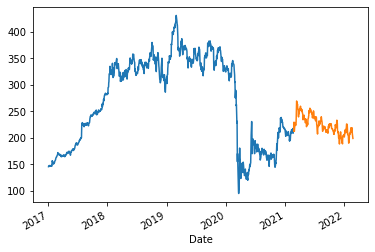

In [163]:
train['price'].plot()
test['price'].plot();

#### Find the autocorrelations of the training data for lags 1-10.

In [164]:
for i in range (1, 11):
    print(train['price'].autocorr(i))

0.9968121625557185
0.9933965688909009
0.989325718361936
0.9852828172430419
0.9809899445584499
0.9765757327152306
0.9723996869778411
0.9679326320170949
0.9635582284870582
0.9587385189122684


#### Plot the autocorrelation using statsmodels `plot_acf`.

In [165]:
# With help from https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

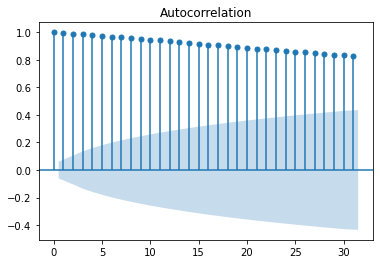

In [166]:

plot_acf(train['price']);

#### Plot the partial autocorrelation values using statsmodels `plot_pacf`.

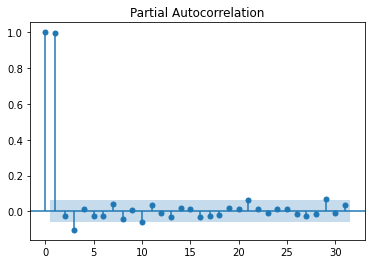

In [167]:
plot_pacf(train['price']);

#### Do any lags have high autocorrelation?

All lags have high autocorrelation

### Baseline model

#### Make a baseline model that is just the last value from the training set, continued into the future.

In [168]:
train['price'].iloc[-1]

212.8800048828125

In [169]:
df_preds = test[['price']]

In [175]:
df_preds['last'] = train['price'].iloc[-1]
df_preds

/var/folders/p1/89v2vyg94jd0blrmm4w41wr00000gn/T/ipykernel_82078/2709553461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds['last'] = train['price'].iloc[-1]


,price,last
Date,,
2021-02-22,212.880005,212.880005
2021-02-23,212.119995,212.880005
2021-02-24,229.339996,212.880005
2021-02-25,216.449997,212.880005
2021-02-26,212.009995,212.880005
...,...,...
2022-02-15,217.729996,212.880005
2022-02-16,218.929993,212.880005
2022-02-17,213.580002,212.880005


#### Plot it

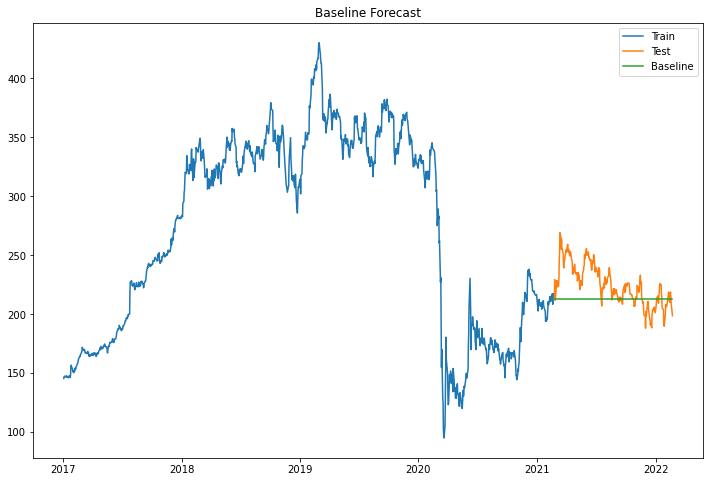

In [176]:
# With help from lesson 9.02
plt.figure(figsize=(12,8))

plt.plot(train.index, train['price'], label='Train')
plt.plot(test.index, test['price'], label='Test')
plt.plot(df_preds.index, df_preds['last'], label="Baseline")

plt.legend(loc='best')
plt.title("Baseline Forecast");

#### Score it on the test set using MAE

In [177]:
# Also with help from lesson 9.02
from sklearn.metrics import mean_squared_error

mean_squared_error(df_preds['price'], df_preds['last'], squared=False)

20.62750285500022

## Autoregression model
"Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step." - [Machine Learning Mastery](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)

#### Using scikit-learn's LinearRegression class, make a model to predict the stock price based on 10 lags. 

In [178]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [183]:
train.dropna(inplace=True)

/Users/andresperez/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [184]:
X_train = train.drop(columns='price')
y_train = train['price']
X_test = test.drop(columns='price')
y_test = test['price']


#### Create and fit your model.

In [185]:
lr.fit(X_train, y_train)

LinearRegression()

In [186]:
lr.score(X_train, y_train)

0.9936465976447875

#### Predict on the test set, plot, and score on MAE.

In [187]:
df_preds['linreg'] = lr.predict(X_test)

/var/folders/p1/89v2vyg94jd0blrmm4w41wr00000gn/T/ipykernel_82078/3376120385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preds['linreg'] = lr.predict(X_test)


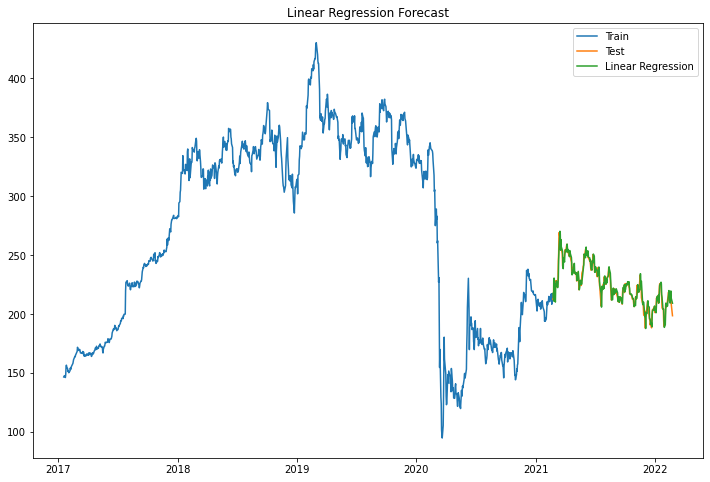

In [188]:
plt.figure(figsize=(12,8))

plt.plot(train.index, train['price'], label='Train')
plt.plot(test.index, test['price'], label='Test')
plt.plot(df_preds.index, df_preds['linreg'], label="Linear Regression")

plt.legend(loc='best')
plt.title("Linear Regression Forecast");

In [189]:
mean_squared_error(df_preds['price'], df_preds['linreg'], squared=False)

5.190395326491589

#### How does this very basic model perform?

Performs better thanm the baseline

In [190]:
lr.score(X_test, y_test)

0.9049481352034923

#### How does it compare to the baseline?

Around 20 RMSE for the baseline vs. 5 for linreg

#### Congratulations! You just made an autoregression model (AR)! 🎉

#### Would your recommend anyone use your model to guide their investment decisions?

Never